# 基于numpy的DNN框架
DNN用于拟合任意函数
(固定除了最后一层每层都用Relu激活函数，采用Adam优化器，Smooth_L1损失函数)

In [151]:
import numpy as np

# 计算平滑L1损失函数的梯度和Loss
def Smooth_L1(y_pred,y,loss):
    gap = y_pred - y
    grad_Z = []
    for i in gap[0]:
        if abs(i) < 1:
            grad_Z.append(i)
            loss += 0.5 * i ** 2
        elif i >= 1:
            grad_Z.append(1)
            loss += abs(i) - 0.5
        else:
            grad_Z.append(-1)
            loss += abs(i) - 0.5
          
    return np.array(grad_Z)[None],loss

# 定义Relu激活函数
def Relu(x):
    t = []
    for i in range(len(x[0])):
        if x[0][i] > 0:
            t.append(x[0][i])
        else:
            t.append(0)
    return np.array(t)[None]

# 计算返回Relu激活函数的梯度
def Relu_inv(x):
    grad_relu = []
    for i in range(len(x[0])):
        if x[0][i] > 0:
            grad_relu.append(1)
        else:
            grad_relu.append(0)
    return np.array(grad_relu)[None]

# 定义感知机
def MLP(x,weight,bias):
    x_enc = np.dot(x,weight)+bias
    x_enc = Relu(x_enc)
    return x_enc

# 定义线性层
def Linearlayer(x,weight,bias):
    y_pred = np.dot(x,weight)+bias
    return y_pred

In [154]:
# 定义神经网络的结构，有几层(不包含输入层)，每层有多少个神经元（N是一个list，记录每层神经元的个数,N的第一个元素是input的个数）
class DNN:
    # 初始化网络结构的属性
    def __init__(self,floor_num,N):
        self.floor_num = floor_num
        self.N = N
        self.loss = 0
        
        # 创建列表保存每一层的参数
        Parameter = []
        # 保存当前层神经元即将输入下一层的x，如何计算得到当前层x的weight和bias
        Floor_parameter = {'x':0,'weight':0,'bias':0}
        Parameter.append(Floor_parameter.copy())
        # 初始化每一层的参数
        for i in range(floor_num):
            Floor_parameter['weight'] = np.random.randn(self.N[i],self.N[i+1])
            Floor_parameter['bias'] = np.random.randn(1,self.N[i+1])
            Parameter.append(Floor_parameter.copy())
        self.Parameter = Parameter
        
        # 创建Adam优化器需要的初始参数
        M = []
        V = []
        Floor_m = {'weight':0,'bias':0}
        Floor_v = {'weight':0,'bias':0}
        M.append(Floor_m.copy())
        V.append(Floor_v.copy())
        # 初始化，与Parameter对齐
        for i in range(floor_num):
            Floor_m['weight'] = np.zeros([self.N[i],self.N[i+1]])
            Floor_m['bias'] = np.zeros([1,self.N[i+1]])
            Floor_v['weight'] = np.zeros([self.N[i],self.N[i+1]])
            Floor_v['bias'] = np.zeros([1,self.N[i+1]])
            M.append(Floor_m.copy())
            V.append(Floor_v.copy())
        self.M = M
        self.V = V

    # 函数作用，计算前向传播，输出预测值
    def forward_propagation(self,x):
        # 定义网络结构，前向传播，保存参数
        for i in range(self.floor_num):
            if i != self.floor_num-1:
                x = MLP(x,self.Parameter[i+1]['weight'],self.Parameter[i+1]['bias'])
                self.Parameter[i+1]['x'] = x
            else:
                x = Linearlayer(x,self.Parameter[i+1]['weight'],self.Parameter[i+1]['bias'])
                self.Parameter[i+1]['x'] = x
        return None
    
    # 函数作用，计算反向传播，求出每一层更新的梯度,输出Loss
    def backward_propagation(self,y):
        # 创建列表保存梯度
        self.Grad = []
        
        grad_Z,self.loss = Smooth_L1(self.Parameter[-1]['x'],y,self.loss)
        # 保存当前层神经元即将输出x的梯度，如何计算得到下一层x的weight和bias的梯度
        Floor_grad = {'x':grad_Z,'weight':0,'bias':0}
        self.Grad.append(Floor_grad.copy())
        
        # 反向传播，计算和保存每一层的梯度
        for j in range(self.floor_num):
            # 与前向传播对齐
            j = self.floor_num - j 
            if j != self.floor_num:
                grad_relu = Relu_inv(self.Parameter[j]['x']) # 1 * len(xi)  
            else:
                grad_relu = np.array([[1]])
            # print("grad_relu:",grad_relu)
            Floor_grad['weight'] = np.dot(self.Parameter[j-1]['x'].T,np.multiply(self.Grad[self.floor_num-j]['x'],grad_relu))
            Floor_grad['bias'] = np.multiply(self.Grad[self.floor_num-j]['x'],grad_relu)
            # 如果不是最浅的层，求出该层的所有梯度，否则不求
            if j != 1:
                Floor_grad['x'] = np.dot(np.multiply(self.Grad[self.floor_num-j]['x'],grad_relu),self.Parameter[j]['weight'].T)
            self.Grad.append(Floor_grad.copy())

        # 与Parameter对齐
        self.Grad.reverse()
        # print(self.Grad)
        return None
    
    def Adam(self,t,lr=0.01,beta1=0.9,beta2=0.999,epsilon=1e-7):
    
        for i in range(self.floor_num):
            for j in ['weight','bias']:
                self.M[i+1][j] = beta1*self.M[i+1][j] + (1-beta1)*self.Grad[i][j]
                self.V[i+1][j] = beta2*self.V[i+1][j] + (1-beta2)*self.Grad[i][j]**2
                m_b = self.M[i+1][j]/(1-beta1**(t+1))
                v_b = self.V[i+1][j]/(1-beta2**(t+1))
                self.Parameter[i+1][j] -= lr*m_b/(np.sqrt(v_b)+epsilon)
        return None

    def train(self,x,y,t):
        x = x[None]
        y = y[None]
        self.Parameter[0]['x'] = x

        self.forward_propagation(x)
        self.backward_propagation(y)
        self.Adam(t)
        return None
            
    def predict(self,x):
        # 执行前向传播，但不更新参数
        x = x[None]
        for i in range(self.floor_num):
            if i != self.floor_num-1:
                x = MLP(x,self.Parameter[i+1]['weight'],self.Parameter[i+1]['bias'])
            else:
                y_pred = Linearlayer(x,self.Parameter[i+1]['weight'],self.Parameter[i+1]['bias'])
        return y_pred

开始训练第0个epoch
模型当前的损失为:  17879.961283545672
开始训练第1个epoch
模型当前的损失为:  13803.666630842994
开始训练第2个epoch
模型当前的损失为:  13053.900224239025
开始训练第3个epoch
模型当前的损失为:  12662.422159024025
开始训练第4个epoch
模型当前的损失为:  12321.80881234957
开始训练第5个epoch
模型当前的损失为:  12195.923928938779
开始训练第6个epoch
模型当前的损失为:  12053.41649963551
开始训练第7个epoch
模型当前的损失为:  12232.283131868528
开始训练第8个epoch
模型当前的损失为:  12124.851719705448
开始训练第9个epoch
模型当前的损失为:  12120.0412697752


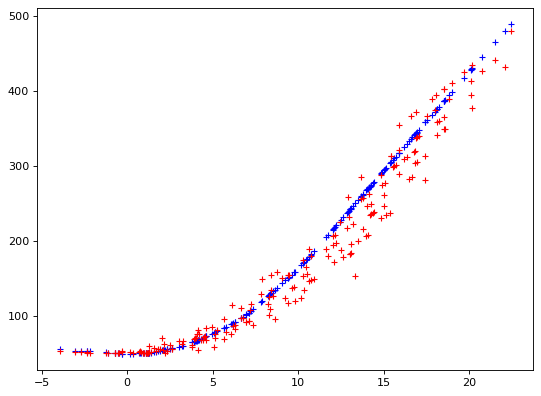

In [159]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

##########################################################
##########################################################
##########################################################
# 创建训练和测试数据和标签，1000列数据,测试集占比0.2
Data_size = 1000
test_size = 0.2
epoch = 10     # 定义训练多少次
##########################################################
##########################################################
##########################################################

np.random.seed(27)
rand_x = np.random.randint(20,size=(Data_size))
np.random.seed(27)
rand_x = rand_x + np.random.randn(Data_size)
##########################################################
##########################################################
##########################################################
rand_y = rand_x**2+50      # 这里定义你要拟合的函数
##########################################################
##########################################################
##########################################################
# 加噪声
np.random.seed(27)
rand_xb = rand_x + np.random.randn(Data_size)


# 划分数据集
X_train,X_test,y_train,y_test = train_test_split(rand_xb,rand_y,test_size=test_size)

# 定义训练和预测的batch函数，batch的值应等于输入神经元的个数(已经设置好了)
def train_batch(batch,model,X_train,y_train):
    X = []
    Y = []
    t = 0
    for i,j in zip(X_train,y_train):
        X.append(i)
        Y.append(j)
        if len(X) == batch:
            model.train(np.array(X),np.array(Y),t)
            X = []
            Y = []
        t += 1
    print('模型当前的损失为: ',model.loss)
    model.loss = 0
    return None

def predict_batch(batch,model,X_test):    
    y_pred = []
    X = []
    for i in X_test:
        X.append(i)
        if len(X) == batch:
            y_p = model.predict(np.array(X))
            y_p = y_p.squeeze()
            if y_p.shape != ():
                for j in y_p:
                    y_pred.append(j)
            else:
                y_pred.append(y_p)
            X = []
    return y_pred

# 模型训练部分
#######################################################################################################
#######################################################################################################
#######################################################################################################
model = DNN(3,[1,64,16,1])        # 定义模型参数(floor_num,N)
#######################################################################################################
# 1. floor_num为神经网络层数，为隐藏层+输出层
# 2. N为每层神经元的个数，如[1,16,16,1]就是指输入输出为1个神经元，中间两层隐藏层都是16个神经元
# 3. floor_num 和 N一定要对应，否则会出错，然后就是输入层和输出层的神经元个数一定要相等，否则也会出错
#######################################################################################################
#######################################################################################################
#######################################################################################################

for i in range(epoch):
    print('开始训练第{}个epoch'.format(i))
    train_batch(model.N[0],model,X_train,y_train)
    
y_pred = predict_batch(model.N[0],model,X_test)

# 比对预测结果
plt.figure(figsize=(8,6),dpi=80)
plt.plot(X_test[:int(Data_size*test_size - Data_size*test_size%model.N[0])],y_pred,'b+')
plt.plot(X_test,y_test,'r+')